# KNN

In [1]:
from transformers import CLIPProcessor, CLIPModel
import torch
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc
import pyarrow.dataset as ds
from PIL import Image
from src.benchmarkers import *
from src.benchmarkersV2 import *
from tqdm import tqdm
import os
import numpy as np
from typing import *
import pickle
import torch
from torchvision import transforms, utils
import framework_functions as ff

c:\Users\Cristiano Lavoro\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [31]:
root_path = r"C:\Users\Cristiano Lavoro\Downloads\CUB_200_2011\CUB_200_2011\CUB_200_2011\images"
#root_path = r"C:\Users\Cristiano Lavoro\Downloads\animals"

classes = sorted(entry.name for entry in os.scandir(root_path) if entry.is_dir())

if not classes:
    raise FileNotFoundError(f"Couldn't find any class folder in {root_path}.")

class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

directory = os.path.expanduser(root_path)

paths_to_images = []
classes_indices = []
classes_labels  = []

for j, target_class in enumerate(sorted(class_to_idx.keys())):
    class_index = class_to_idx[target_class]
    target_dir = os.path.join(directory, target_class)
    if not os.path.isdir(target_dir):
        continue
    for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)): 
        for i, fname in enumerate(sorted(fnames)):
            path = os.path.join(root, fname)
            paths_to_images.append(path)
            classes_indices.append(class_index)
            classes_labels.append(target_class)

class SpeciesDataset(torch.utils.data.Dataset):
    def __init__(self,paths):
        self.paths_to_images = paths
    def __len__(self):
        return len(self.paths_to_images)
    
    def __getitem__(self,idx):
        transform = transforms.Compose([
                    transforms.Lambda(lambda img: img.convert("RGB")),
                    transforms.Resize((500, 500)),  # Resize to a square shape
                    #transforms.ToTensor(),          # Convert image to tensor
                    ])
        return np.array(transform(Image.open(self.paths_to_images[idx])))
        

# Embeddings calculations Clip

In [ ]:
from transformers import CLIPProcessor, CLIPModel

batch_size = 64
shuffle = False
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)
model.eval()

In [58]:
dataset = SpeciesDataset(paths_to_images)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=shuffle)


embeddings = []

for X in tqdm(dataloader):
    X.to(device)
    inputs = processor(images=X, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    
    embeddings.append(outputs.cpu())

with open(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\knn_outputs\embeddings_animals.pkl", 'wb') as file:
    pickle.dump(embeddings, file)

  0%|          | 0/85 [00:00<?, ?it/s]

100%|██████████| 85/85 [05:54<00:00,  4.18s/it]


# Embeddings calculations ResNet

In [34]:
import torch
import timm

batch_size = 64
shuffle = False
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = timm.create_model('resnet50', pretrained=True, num_classes=0)

model.to(device)
model.eval()


class ResNetDataset(torch.utils.data.Dataset):
    def __init__(self,paths):
        self.paths_to_images = paths
    def __len__(self):
        return len(self.paths_to_images)
    
    def __getitem__(self,idx):
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.Lambda(lambda img: img.convert("RGB")),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        return transform(Image.open(self.paths_to_images[idx]))

In [35]:
dataset = ResNetDataset(paths_to_images)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=shuffle)


embeddings = []

for X in tqdm(dataloader):
    X = X.to(device)
    with torch.no_grad():
        tmp = model(X)
        embeddings.append(tmp)

with open(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\knn_outputs\embeddings_species_resnet.pkl", 'wb') as file:
    pickle.dump(embeddings, file)

100%|██████████| 185/185 [08:19<00:00,  2.70s/it]


# Dataset 1 (all animals)

In [2]:
#root_path = r"C:\Users\Cristiano Lavoro\Downloads\CUB_200_2011\CUB_200_2011\CUB_200_2011\images"
root_path = r"C:\Users\Cristiano Lavoro\Downloads\animals"

classes = sorted(entry.name for entry in os.scandir(root_path) if entry.is_dir())

if not classes:
    raise FileNotFoundError(f"Couldn't find any class folder in {root_path}.")

class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

directory = os.path.expanduser(root_path)

paths_to_images_animals = []
classes_indices_animals = []
classes_labels_animals  = []

for j, target_class in enumerate(sorted(class_to_idx.keys())):
    class_index = class_to_idx[target_class]
    target_dir = os.path.join(directory, target_class)
    if not os.path.isdir(target_dir):
        continue
    for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)): 
        for i, fname in enumerate(sorted(fnames)):
            path = os.path.join(root, fname)
            paths_to_images_animals.append(path)
            classes_indices_animals.append(class_index)
            classes_labels_animals.append(target_class)

with open(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\knn_outputs\resnet\all_animals\embeddings_animals_resnet.pkl", 'rb') as file:
    embeddings_animal_to_manipulate = pickle.load(file)

embeddings_animal_to_manipulate_1 = [item.tolist() for item in embeddings_animal_to_manipulate]
embeddings_animals = [item for sublist in embeddings_animal_to_manipulate_1 for item in sublist]


In [41]:
output = []
for s in range(len(paths_to_images_animals)):
    sample = {
        "image_feature":[{
            "image" : paths_to_images[s],
            "class_feature":[
                {
                    "label" : classes_indices[s],
                    "dataset" : "dataset_1_animals"
                }
            ],
            "embedding_feature":[
                {
                    "vector" : embeddings_animals[s]
                }
            ]
        }]
    }
    output.append(sample)

In [42]:
table = pa.Table.from_pylist(output)
ff.partition_dataset(table,r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\knn_outputs\resnet\all_animals", max_batch_size=300, mode = "stream")

# Dataset 2 (species)

In [3]:
root_path = r"C:\Users\Cristiano Lavoro\Downloads\CUB_200_2011\CUB_200_2011\CUB_200_2011\images"
#root_path = r"C:\Users\Cristiano Lavoro\Downloads\animals"

classes = sorted(entry.name for entry in os.scandir(root_path) if entry.is_dir())

if not classes:
    raise FileNotFoundError(f"Couldn't find any class folder in {root_path}.")

class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

directory = os.path.expanduser(root_path)

paths_to_images_species = []
classes_indices_species = []
classes_labels_species  = []

for j, target_class in enumerate(sorted(class_to_idx.keys())):
    class_index = class_to_idx[target_class]
    target_dir = os.path.join(directory, target_class)
    if not os.path.isdir(target_dir):
        continue
    for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)): 
        for i, fname in enumerate(sorted(fnames)):
            path = os.path.join(root, fname)
            paths_to_images_species.append(path)
            classes_indices_species.append(class_index)
            classes_labels_species.append(target_class)

with open(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\knn_outputs\resnet\species\embeddings_species_resnet.pkl", 'rb') as file:
    embeddings_species_to_manipulate = pickle.load(file)

embeddings_species_to_manipulate_1 = [item.tolist() for item in embeddings_species_to_manipulate]
embeddings_species = [item for sublist in embeddings_species_to_manipulate_1 for item in sublist]

In [45]:
output = []
for s in range(len(paths_to_images_species)):
    sample = {
        "image_feature":[{
            "image" : paths_to_images[s],
            "class_feature":[
                {
                    "label" : classes_indices[s],
                    "dataset" : "dataset_1_animals"
                }
            ],
            "embedding_feature":[
                {
                    "vector" : embeddings_species[s]
                }
            ]
        }]
    }
    output.append(sample)

In [46]:
table_2 = pa.Table.from_pylist(output)
ff.partition_dataset(table_2,r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\knn_outputs\resnet\species", max_batch_size=300, mode = "stream")

# Faiss KNN

In [80]:
np.load(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\knn_outputs\resnet\to_merge\I.npy",allow_pickle=True)[index]

array([4636, 4642, 4658, 4629, 4661, 4653], dtype=int64)

In [81]:
np.load(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\knn_outputs\resnet\to_merge\D.npy",allow_pickle=True)[index]

array([0.33927453, 0.36768556, 0.38372743, 0.40699792, 0.41572368,
       0.41995037], dtype=float32)

006.Least_Auklet


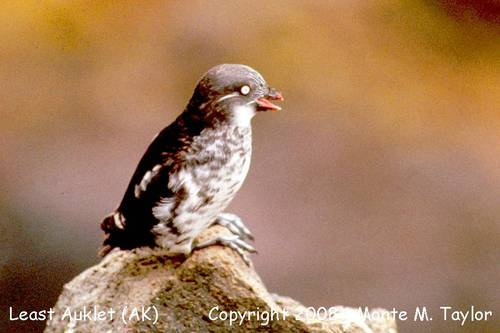

In [120]:
index = 299
print(classes_labels_species[index])
Image.open(paths_to_images_species[index])

woodpecker
88


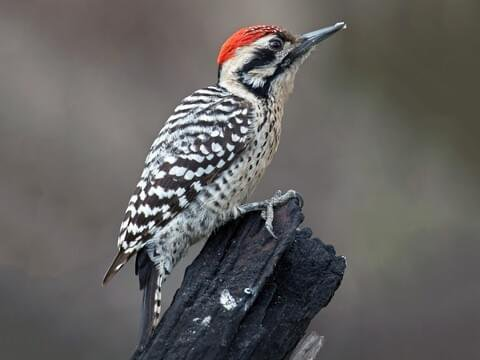

In [122]:
index = 5301   
print(classes_labels_animals[index])
print(classes_indices_animals[index])
Image.open(paths_to_images_animals[index])

In [78]:
paths_to_images_species.index(r"C:\Users\Cristiano Lavoro\Downloads\CUB_200_2011\CUB_200_2011\CUB_200_2011\images\121.Grasshopper_Sparrow\Grasshopper_Sparrow_0039_115980.jpg")

7047

# Combine Datasets

In [4]:
import FAISS as knn

In [2]:
root_path_animal = "../benchmarks/knn_outputs/all_animals"
root_path_species = "../benchmarks/knn_outputs/species"
root_path_to_merge ="../benchmarks/knn_outputs/to_merge"

In [5]:
root_path_animal = "../benchmarks/knn_outputs/resnet/all_animals"
root_path_species = "../benchmarks/knn_outputs/resnet/species"
root_path_to_merge ="../benchmarks/knn_outputs/resnet/to_merge"

In [10]:
#with pa.OSFile(f"{root_path_merge}/ds_{1}_of_{26}_stream.arrows", 'rb') as source:
#        table_to_merge = pa.ipc.open_stream(source).read_all()
#for i in list(range(2,27)):
#        with pa.OSFile(f"{root_path_merge}/ds_{i}_of_{26}_stream.arrows", 'rb') as source:
#                table_to_merge = pa.concat_tables([table_to_merge,pa.ipc.open_stream(source).read_all()])
#table_to_merge = table_to_merge.combine_chunks()

In [6]:
merged_table, I,D = knn.knn(root_path_animal,
        root_path_species,
        root_path_to_merge,
        ["image_feature","embedding_feature","vector"],
        ["image_feature","embedding_feature","vector"],
        ["image_feature","class_feature","label"],
        6,
        35)

: 

In [94]:
lista = [4,None,4,4,None,None]

lista.count(6)

0

In [98]:
from collections import defaultdict

# Example lists
integers = [1, 2, 1, 3, 2, 3]
doubles = [1.1, 2.2, 1.2, 3.1, 2.1, 3.2]

# Grouping the doubles by their corresponding integers
grouped = defaultdict(list)

for i, d in zip(integers, doubles):
    grouped[i].append(d)

# Convert defaultdict to a regular dictionary if needed
grouped_dict = dict(grouped)

print(grouped_dict)

for k,v in grouped_dict.items():
    print(k)
    print(v)

1
1.1
2
2.2
1
1.2
3
3.1
2
2.1
3
3.2


In [117]:
classes_indices_animals.index(89)

5340

In [118]:
classes_labels_animals[5340]

'zebra'